In [5]:
# IRIS DATA SETİNİN DEEP LEARNİNG UYGULAMASI
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# verilerin okunması
veriler=pd.read_csv("https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv")
veriler

In [ ]:
# bağımlı ve bağımsız verilerin alınması
X=veriler.drop(["species"],axis=1)
Y=veriler["species"]
X.head()

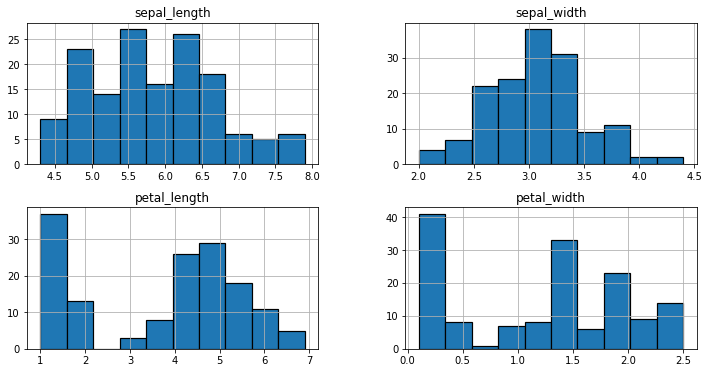

In [6]:
#visualize the data Y
veriler.hist(edgecolor='black', linewidth=1.2)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [41]:
# Normalizasyon işlemleri
#--------------------------------------------------------
# Gerekli kütüphanelerin yüklenmesi
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import models

ct=make_column_transformer(
    (MinMaxScaler(),["sepal_length","sepal_width","petal_length","petal_width"])) #geri kalanlar encoding e gidecek

# bağımlı ve bağımsız verilerin alınması
X=veriler.drop(["species"],axis=1)
Y=veriler["species"]
# OneHotEncoding for Y
Y = pd.get_dummies(Y).values
#Build our train and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

#Fit the column transformer to our training data
ct.fit(X_train)

#Transform training and test data with normalization
X_train_normal=ct.transform(X_train)
X_test_normal=ct.transform(X_test)

In [56]:
# nueral network function
def build_model():
  #setting seed
  tf.random.set_seed(42)
  #Modelin oluşturulması
  model = models.Sequential([
      tf.keras.layers.Dense(100, input_shape=(4,), activation="relu"),
      tf.keras.layers.Dropout(.2),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dropout(.5),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dropout(.2),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(3, activation="softmax")
  ])
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["categorical_accuracy"]
              )
  return model


In [ ]:
#K Fold Cross Validation
#----------------------------
k = 5
num_val_samples = len(X_train_normal) // k
num_epochs = 100
num_classes=3
all_scores = []

for i in range(k):
    print(f'Processing fold # {i}')
    val_data = X_train_normal[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = Y_train[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
                            [X_train_normal[:i * num_val_samples],
                            X_train_normal[(i+1) * num_val_samples:]],
                            axis=0)
    partial_train_targets = np.concatenate(
                            [Y_train[:i * num_val_samples],
                            Y_train[(i+1)*num_val_samples:]],
                            axis=0)
    model = build_model()
    history=model.fit(partial_train_data,
              partial_train_targets,
              epochs=num_epochs,
              batch_size=32,
              verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [119]:
# Evaluate the model
Y_pred=model.predict(X_test_normal)
model.evaluate(X_test_normal,Y_test)

1/1 [==============================] - 0s 26ms/step - loss: 0.1273 - categorical_accuracy: 0.9667


[0.12734845280647278, 0.9666666388511658]

Text(0.5, 1.0, 'model_iris Loss Curve')

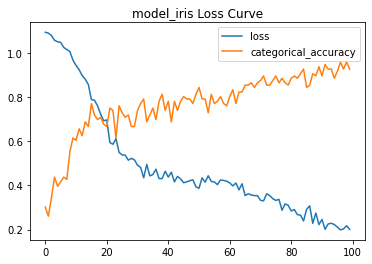

In [120]:
# Plot the Loss Curve 
pd.DataFrame(history.history).plot()
plt.title("model_iris Loss Curve")

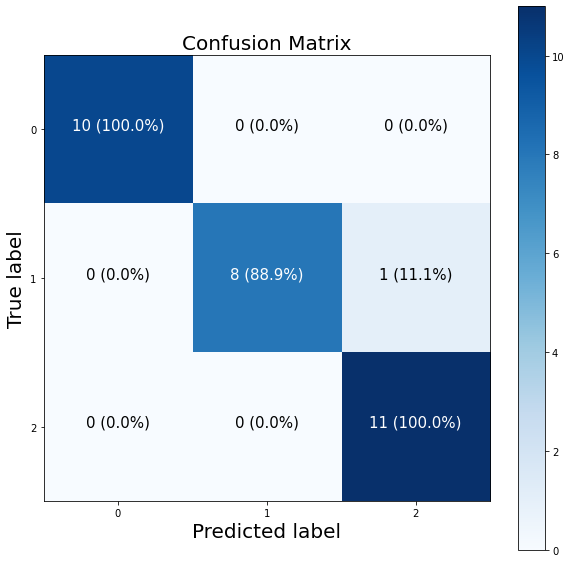

In [121]:
#CONFUSİON MATRİX 
#--------------------------------------------------

import itertools
#confusion matrix
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) 
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

In [122]:
# Recall and Precision 
#---------------------
from sklearn.metrics import precision_score, recall_score
# Convert predictions to binary (0/1) format
y_pred_binary = tf.round(Y_pred)
# Calculate precision and recall scores
precision = precision_score(Y_test, y_pred_binary, average='macro')
recall = recall_score(Y_test, y_pred_binary, average='macro')
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Precision: 0.972
Recall: 0.963


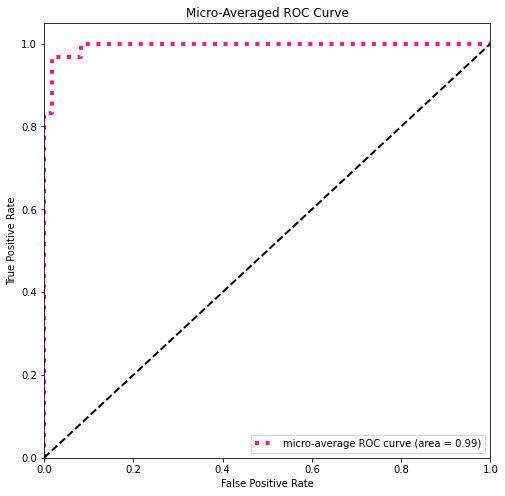

In [123]:
# ROC-AUC Eğrisi
#-----------------
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# her sınıf için fpr, tpr, threshold hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-averaged ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# çizim
plt.figure(figsize=(8,8))
plt.plot(fpr["micro"], tpr["micro"], 
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # x=y doğrusu

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.show()

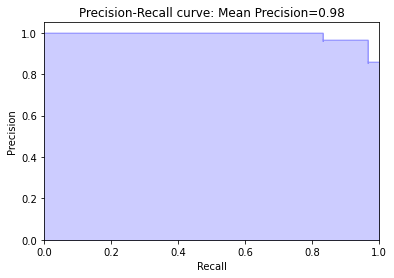

In [124]:
# Precision-Recall Eğrisi
from sklearn.metrics import precision_recall_curve
# precision-recall değerlerini alma
precision, recall, thresholds = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())

# mean precision hesaplama
mean_precision = np.mean(precision)

# PR eğrisini çizme
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall curve: Mean Precision={mean_precision:.2f}')
plt.show()

In [125]:
# Metrikler
#------------
from sklearn.metrics import precision_recall_fscore_support
# Tahminlerden etiketleri elde et
y_pred_labels = np.argmax(Y_pred, axis=1)
y_true_labels = np.argmax(Y_test, axis=1)

# Sınıf bazında precision, recall ve f1 skorlarını hesapla
precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average=None)

# Her bir sınıfın F1 skorunu yazdır
for i in range(num_classes):
    print(f'Class {i} F1 Score: {f1[i]}')

# Tüm sınıfların F1 skorunun ortalamasını hesapla
f1_macro = np.mean(f1)
print(f'Macro-average F1 Score: {f1_macro}')

# Her bir sınıfın doğru tahmin oranını hesapla
true_positives = np.zeros(num_classes)
false_negatives = np.zeros(num_classes)
for i in range(num_classes):
    true_positives[i] = np.sum((y_true_labels == i) & (y_pred_labels == i))
    false_negatives[i] = np.sum((y_true_labels == i) & (y_pred_labels != i))
true_negatives = np.sum((y_true_labels != i) & (y_pred_labels != i))
false_positives = np.sum((y_true_labels != i) & (y_pred_labels == i))

# Her bir sınıfın specificity ve sensitivity skorlarını hesapla
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Tüm sınıfların specificity ve sensitivity skorlarının ortalamasını hesapla
sensitivity_macro = np.mean(sensitivity)
specificity_macro = np.mean(specificity)
print(f'Macro-average Sensitivity: {sensitivity_macro}')
print(f'Macro-average Specificity: {specificity_macro}')

Class 0 F1 Score: 1.0
Class 1 F1 Score: 0.9411764705882353
Class 2 F1 Score: 0.9565217391304348
Macro-average F1 Score: 0.9658994032395567
Macro-average Sensitivity: 0.9629629629629629
Macro-average Specificity: 0.9473684210526315
